# OOF holography
Te OOF holography computes an aperture distribution model, $\underline{E_\text{a}}(x, y)$, calculates its Fourier transform ($P(u, v)$), and later compares it to an observed power pattern, $P^\text{obs}(u, v)$. The comparison is made by a nonlinear least squares minimization. Once the minimum residual is found, the aperture phase distribution can be computed using the Zernike circle polynomials parametrization (see `aperture.ipynb`).

In [1]:
# Adjustin notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from scipy.constants import c, golden
import pyoof
from pyoof import aperture, telgeometry

In [3]:
# Plotting parameters, to make it nicer :) 
matplotlib.rcParams['figure.figsize'] = (golden * 7, 7)
matplotlib.rcParams['figure.subplot.wspace'] = 0.5
matplotlib.rcParams['figure.subplot.left'] = 0.1
matplotlib.rcParams['figure.subplot.bottom'] = 0.2
matplotlib.rcParams['figure.subplot.right'] = 1
matplotlib.rcParams['figure.subplot.top'] = 0.85
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 15

We start with the definitions of the telescope, for ease the Effeslberg telescope will be chosen. It is also possible to change the telescope geometry by changing the blockage distribution, $B(x, y)$, and/or the optical path difference (OPD) function, $\delta(x, y; d_z)$. This is done by using the functions `block_manual` and `opd_manual`.

In [9]:
pr = 50. # primary reflector radius m

# telescope = [blockage, delta, pr, name]
telescope = dict(
    effelsberg=[
        telgeometry.block_effelsberg,
        telgeometry.opd_effelsberg,
        pr,
        'effelsberg'
        ]
    )

illumination = dict(
    gaussian=[aperture.illum_gauss, 'gaussian', 'sigma_dB'],
    pedestal=[aperture.illum_pedestal, 'pedestal', 'c_dB']
    )

The most important parameters to generate data are the illumination coefficients, `I_coeff`, and the Zernike circle polynomials coefficients, `K_coeff`. Some given initial data is also important, such as the frequency of observation (for long wavelength 32 GHz) and the radial offset in meters (of the order of centimeters). Finally telescopes aspects and geometry such as the blockage and OPD, and FFT2 dimensions, `box_factor` and `resolution`.

In [5]:
# Data generator to test pyoof
freq = 32e9  # Hz
d_z = np.array([-0.022, 0., 0.022])  # radial off set m

n = 5  # initial order
N_K_coeff = (n + 1) * (n + 2) // 2
I_coeff = np.array([1, -14, 0, 0])  # illumination coefficients
K_coeff = np.random.normal(0., .08, N_K_coeff)  # random Zernike circle coeff.

# Generated beam data in a fits file
beam_fits = pyoof.beam_generator(
    params=np.hstack((I_coeff, K_coeff)),
    freq=freq,
    d_z=d_z,
    telgeo=telescope['effelsberg'][:-1],
    illum_func=illumination['pedestal'][0],
    noise=500,
    resolution=2 ** 8,
    box_factor=5,
    save=False
    )

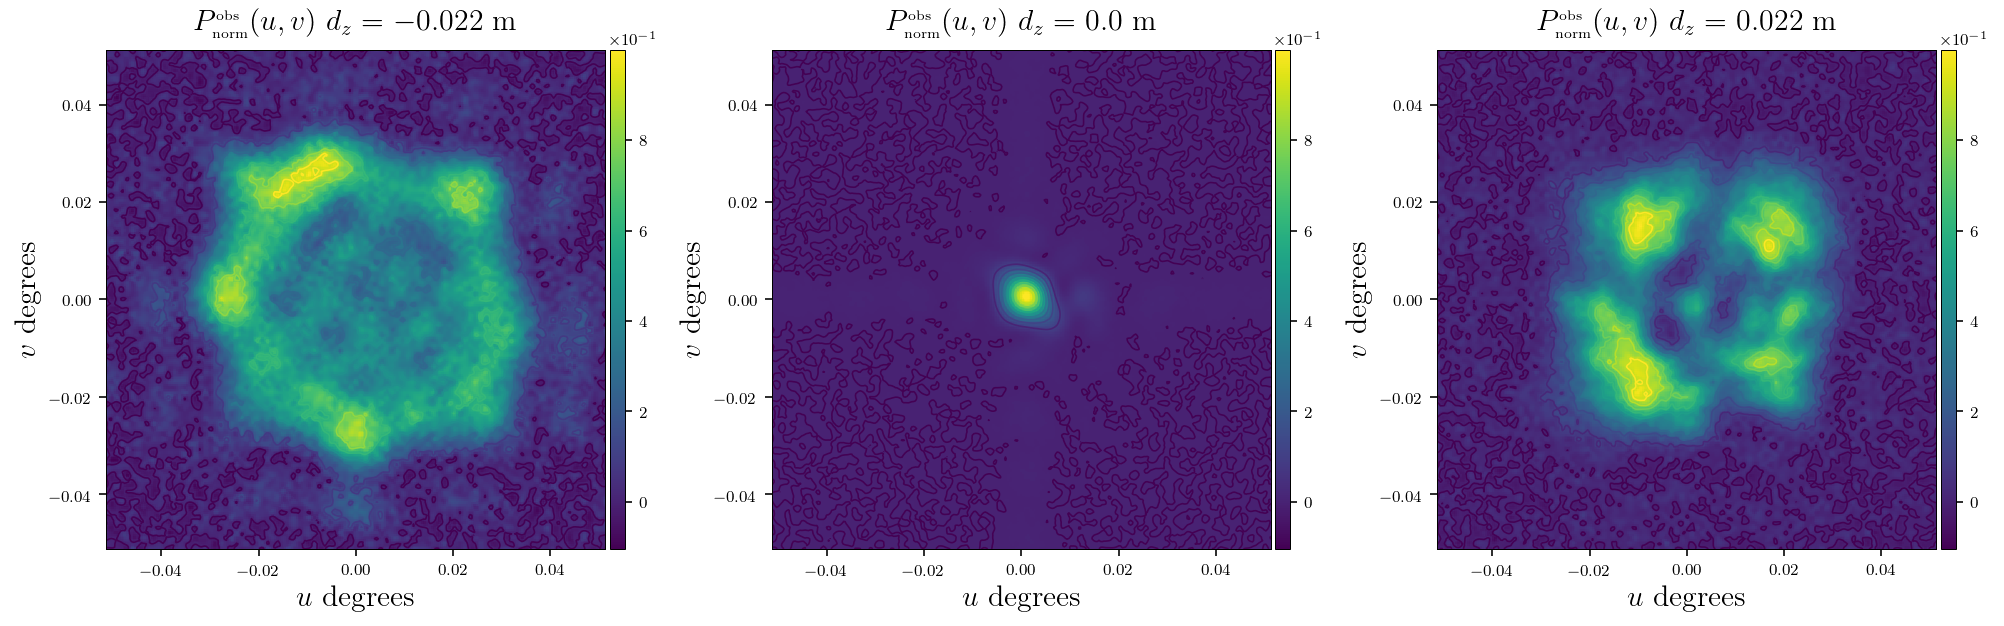

In [6]:
# Extracting the data from the created fits file (on memory)
data_info, data_obs = pyoof.open_fits_pyoof(beam_fits, 'test_notebook')
[name, obs_object, obs_date, pthto, freq, wavel, d_z, meanel] = data_info
[beam_data, u_data, v_data] = data_obs

# plotting the generated data
fig = pyoof.plot_data(
    u_data=u_data,
    v_data=v_data,
    beam_data=beam_data,
    d_z=d_z,
    angle='degrees',
    title='',
    res_mode=False
    )

In [8]:
pyoof.fit_beam(
    data_info=data_info,
    data_obs=[beam_data, u_data, v_data],
    method='trf',  # optimization algorithm 'trf', 'lm' or 'dogbox'
    order_max=5,  # it'll fit from 1 to order_max
    illumination=illumination['pedestal'],
    telescope=telescope['effelsberg'],
    config_params_file=None,  # default or add path config_file.yaml
    fit_previous=True,  # True is recommended
    resolution=2**8,  # standard is 2 ** 8
    box_factor=5,  # box_size = 5 * pr, better pixel resolution
    make_plots=True,
    verbose=0
    )


 ******* PYOOF FIT POWER PATTERN ******* 

... Reading data ... 

Maximum order to be fitted:  5
Telescope name:  effelsberg
File name:  test_notebook
Obs frequency:  32000000000.0 Hz
Obs Wavelength :  0.0094 m
d_z (out-of-focus):  [-0.022  0.     0.022] m
Illumination to be fitted:  pedestal
Initial params: default

 **** PYOOF FIT COMPLETED AT 2.71 mins **** 



In [10]:
ls pyoof_out/test_notebook-000

beam_data.csv    cov_n5.csv       grad_n5.csv      phase_n5.csv
corr_n1.csv      fitpar_n1.csv    jac_n1.csv       plots/
corr_n2.csv      fitpar_n2.csv    jac_n2.csv       pyoof_info.yaml
corr_n3.csv      fitpar_n3.csv    jac_n3.csv       res_n1.csv
corr_n4.csv      fitpar_n4.csv    jac_n4.csv       res_n2.csv
corr_n5.csv      fitpar_n5.csv    jac_n5.csv       res_n3.csv
cov_n1.csv       grad_n1.csv      phase_n1.csv     res_n4.csv
cov_n2.csv       grad_n2.csv      phase_n2.csv     res_n5.csv
cov_n3.csv       grad_n3.csv      phase_n3.csv     u_data.csv
cov_n4.csv       grad_n4.csv      phase_n4.csv     v_data.csv


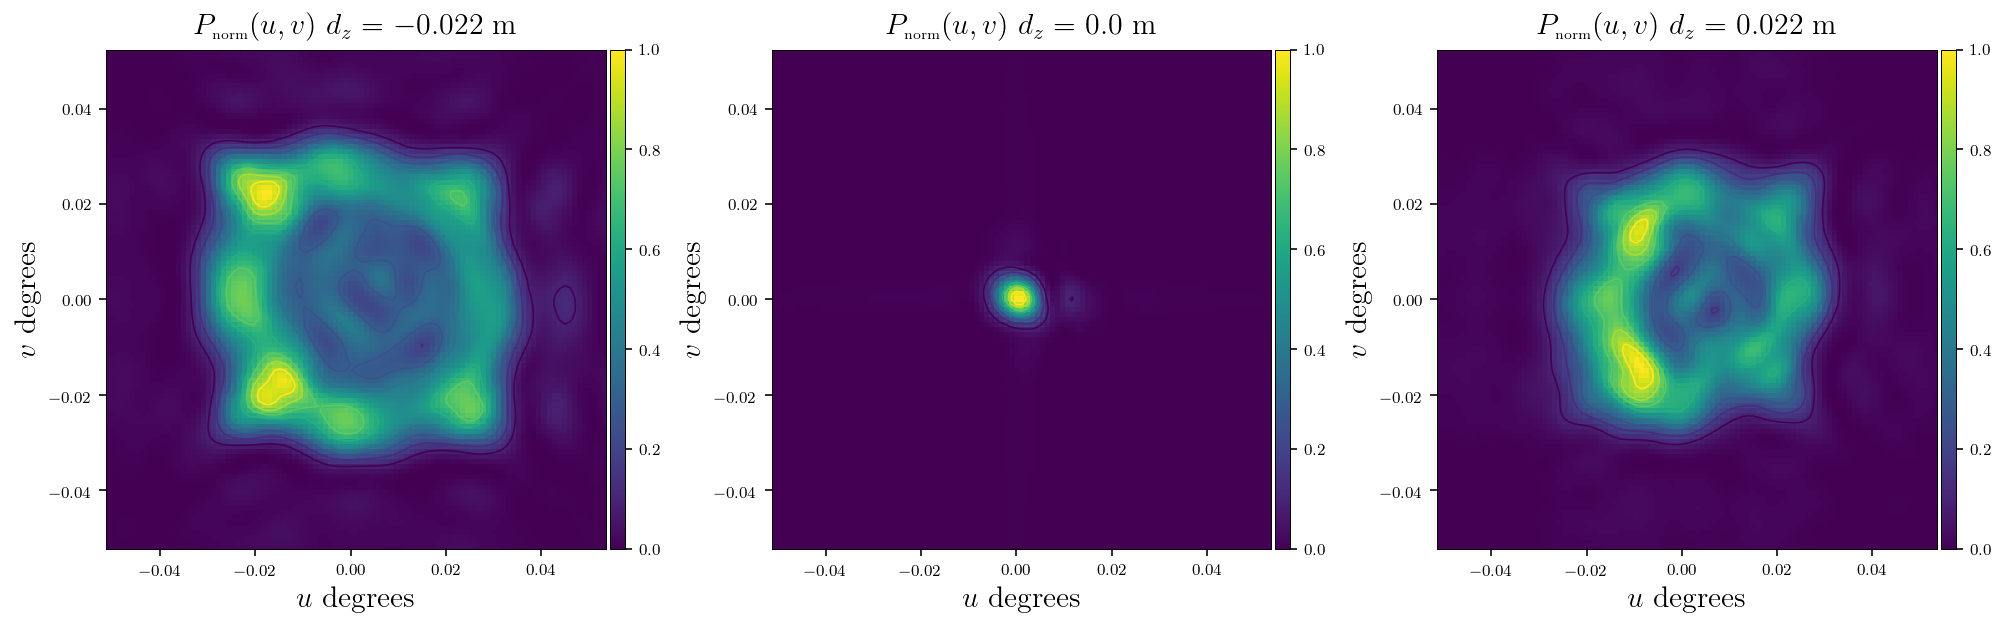

In [12]:
params = ascii.read('pyoof_out/test_notebook-000/fitpar_n3.csv')['parfit']

plt.close(fig)
fig = pyoof.plot_beam(
    params=params,
    title='',
    d_z=d_z,
    wavel=wavel,
    illum_func=illumination['pedestal'][0],
    telgeo=telescope['effelsberg'][:-1],
    plim_rad=None,
    angle='degrees',
    resolution=2 ** 8,
    box_factor=5
    )

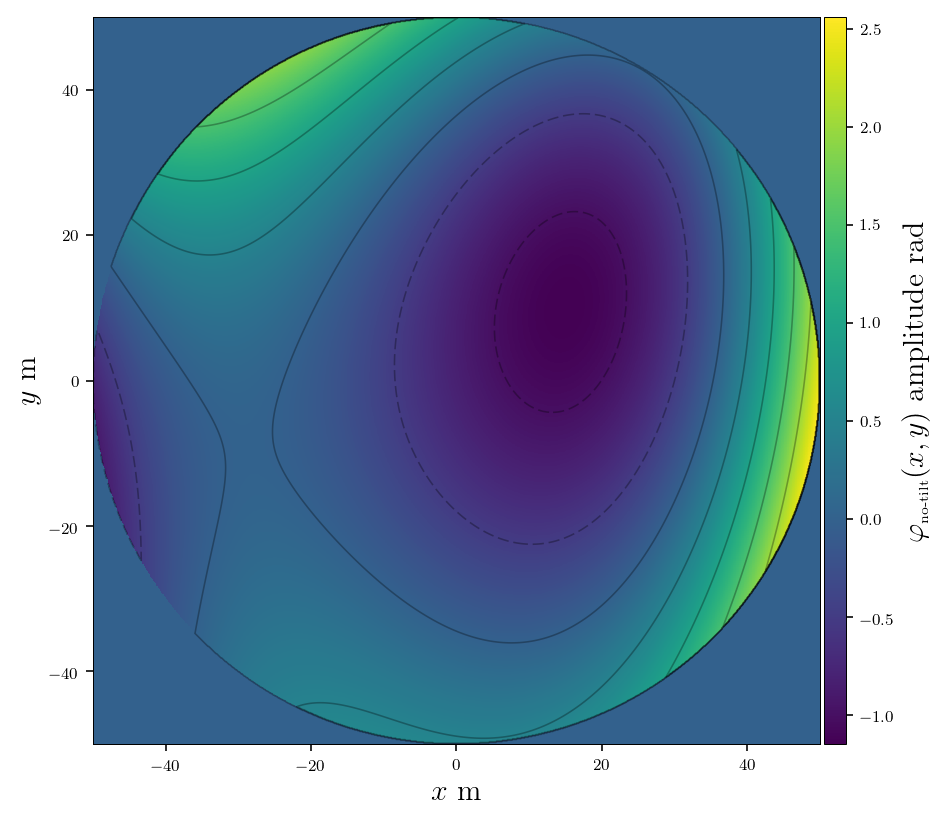

In [18]:
phase = np.genfromtxt('pyoof_out/test_notebook-000/phase_n5.csv')
plt.close(fig)
fig1 = pyoof.plot_phase(K_coeff=params[4:], notilt=True, pr=pr, title='')

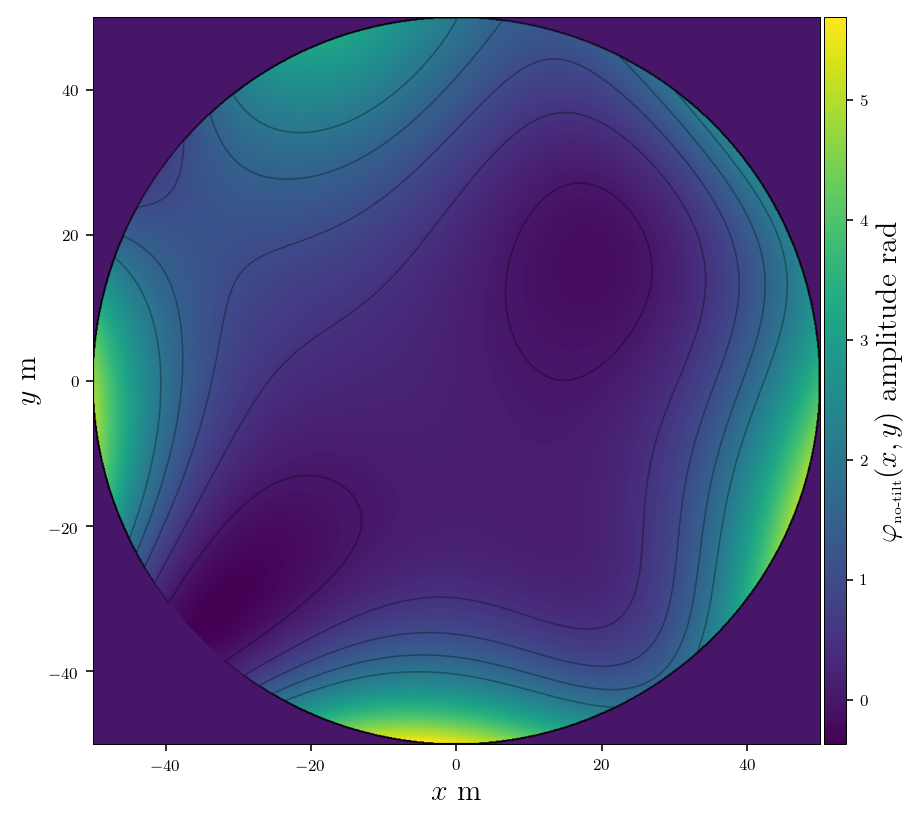

In [19]:
fig2 = pyoof.plot_phase(K_coeff=K_coeff, notilt=True, pr=pr, title='')